In [55]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

In [56]:
# Functie om verbruik vorige dag als feature meegeven, kan ook meerdere dagen meenemen als je n_in groter dan 1 maakt.

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [57]:
# Tijdreeks stationair maken

def stationary(df):
    verschillen_perdag_verbruik = []
    for i in range(len(df) -1 ):
        verschil = df.iloc[i+1, 0] - df.iloc[i, 0]
        verschillen_perdag_verbruik.append(float(verschil))
    
    df['stationair'] = 0
    df['stationair'].iloc[1:] = verschillen_perdag_verbruik
    
    return df

In [58]:
# Funcite om de features dayofweek en month toe te voegen.

def create_features(df):
    
    df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    return df

In [71]:
# loop over alle huisjes met goede data, om voor elke huisje een voorspelling te doen voor het energie verbruik per dag 
# van november en december.

RMSE = list()
R2 = list()


huisjes = [1,2,3,4,5,6,7,9,10,11,12,14,15,16,17,19,20,22,23,24,26,28,30,37,38,39,40,41,42,43,44,46,47,48,50,51,52,54,55,56,57,
           58,60,61,63,64,66,67,69,70,71,72,73,74,75,76,77,79,80,81,83,84,88,91,92,93,94,95,98,99,100,102,104,105,106,110,112,
           113,114,115,116,117,120]

for i in huisjes:
    huis = "df0" + str(i) + "_perdag"
    df = pd.read_csv(huis, index_col=0)
    df_new = pd.DataFrame(df.perdag_verbruik).dropna()
    df_new.index = pd.to_datetime(df_new.index)
    
    df_newer = series_to_supervised(df_new, n_in=1)
    
    df_new['1dag'] = 0
    df_new['1dag'][1:] = df_newer[:, -2]
    
    df_stat = stationary(df_new)
    
    train = df_stat.loc[(df_stat.index < '2019-11-1')]
    test = df_stat.loc[(df_stat.index >= '2019-11-1')]
    
    df2 = create_features(df_stat)
    
    train = create_features(train).dropna()
    train = train.drop(columns = 'perdag_verbruik')
    test = create_features(test).dropna()
    test = test.drop(columns = 'perdag_verbruik')
    TARGET = 'stationair'
    X_train = train.drop(columns= TARGET)
    y_train= train[TARGET]
    X_test = test.drop(columns = TARGET)
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(n_estimators=1000, verbosity=0)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=False)
    yhat = reg.predict(X_test)

    real = df_stat.loc[(df_stat.index >= '2019-10-31')]
    real = real['perdag_verbruik'][:-1]
    real = pd.DataFrame(real)
    prediction= list(yhat)
    real['pred_stat'] = prediction
    new = np.array(real['perdag_verbruik'])+np.array(real['pred_stat'])
    emptys = [np.nan]
    newer = list(new)
    emptys.extend(newer)
    real['real_prediction'] = emptys[:-1]
 
    rmse = np.sqrt(MSE(real['perdag_verbruik'][1:], real['real_prediction'][1:]))
    RMSE.append(rmse)
    r2 = r2_score(real['perdag_verbruik'][1:], real['real_prediction'][1:])
    R2.append(r2)

/tmp/ipykernel_7485/81665306.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['1dag'][1:] = df_newer[:, -2]
/tmp/ipykernel_7485/2026128161.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stationair'].iloc[1:] = verschillen_perdag_verbruik
/tmp/ipykernel_7485/2618434658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/tm

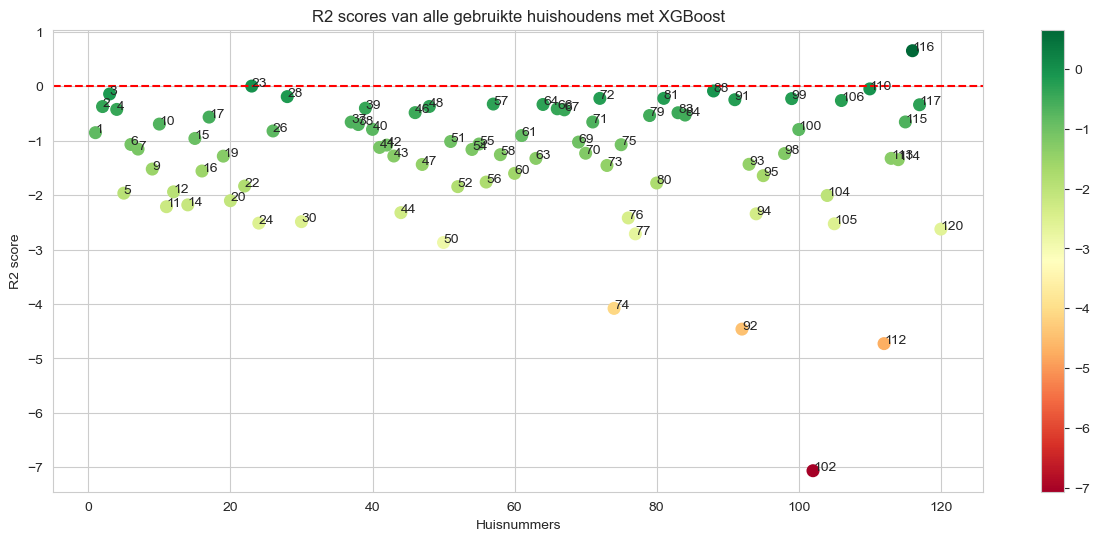

In [80]:
# visualisatie R2 scores per huisje

z = [i for i in huisjes]
y = [j for j in R2]
n = [i for i in huisjes]

fig, ax = plt.subplots(1, figsize=(15,6))
ax.scatter(z, y)

points = ax.scatter(z, y, c=y, s=70, cmap='RdYlGn')
fig.colorbar(points)

plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('R2 scores van alle gebruikte huishoudens met XGBoost')
plt.ylabel('R2 score')
plt.xlabel('Huisnummers')
for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))